### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools

%matplotlib inline

### Functions

In [20]:
def classes_counter(dataset,mode=0):
    if mode==0:
        K = len(set(dataset.targets.numpy()))
    elif mode==1:
        K = len(set(dataset.targets))
        
    return K

def dataloader_batch(train_dataset,test_dataset,batch_size=128):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    # to prevent unwanted correlation in train_data we shuffle train data
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    return train_loader,test_loader


def create_model_and_train(K,train_dataset,test_dataset,model_mode="CNN",batch_size=128,n_epochs=100):
    if model_mode=="CNN":
        model = CNN(K)
    elif model_mode=="Linear":
        model = nn.Sequential(
            nn.Linear(3072,4096),
            nn.ReLU(),
            nn.Linear(4096,8192),
            nn.ReLU(),
            nn.Linear(8192,8192),
            nn.ReLU(),
            nn.Linear(8192,4096),
            nn.ReLU(),
            nn.Linear(4096,2048),
            nn.ReLU(),
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10),
            )

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_loader,test_loader = dataloader_batch(train_dataset,test_dataset,batch_size=batch_size)
    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            if model_mode=="Linear":
                inputs = inputs.view(-1,3072)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in test_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            if model_mode=="Linear":
                inputs = inputs.view(-1,3072)
            
            outputs = model(inputs)

            loss = criterion(outputs, targets)
                        
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it]  = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
        
    return model,train_losses, test_losses, device, train_loader, test_loader

def tmp_loader_show(train_dataset):
    tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=1,shuffle=True)
    for x,y in tmp_loader:
        print(x)
        print(x.shape)
        break
        
        
def plot_test_and_train_metric(train, test, metric):
    plt.plot(train, label=f"train {metric}")
    plt.plot(test, label =f"test {metric}")
    plt.legend()
    plt.show
    

def acc_compouter(model,device,data_loader,model_mode="CNN"):
    n_correct=0.
    n_total=0.
    
    for inputs,targets in data_loader:
        inputs,targets = inputs.to(device), targets.to(device)
        if model_mode=="Linear":
            inputs = inputs.view(-1,3072)

        outputs = model(inputs)
        
        _,predictions = torch.max(outputs,1)
        # 1 is the axis and  _ is the max value that is not needed here
        
        n_correct += (predictions == targets).sum().item()
        # .item() from torch to simple python data type
        n_total += targets.shape[0]
        
    train_acc = n_correct/n_total

    return train_acc

def predict_model(model,data_loader,dataset,device,model_mode="CNN",mode=0):
    if mode==0:
        x = dataset.data.numpy()
        y = dataset.targets.numpy()
    elif mode==1:
        x = dataset.data
        y = dataset.targets
    
    p = np.array([])
    for inputs,targets in data_loader:
        inputs = inputs.to(device)
        if model_mode=="Linear":
            inputs = inputs.view(-1,3072)
        
        outputs = model(inputs)
        _,predictions = torch.max(outputs,1)
        p = np.concatenate((p,predictions.cpu().numpy()))
        
    return p,y,x

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

### Load Data

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root=".",train=True,transform = transforms.ToTensor(),download=True)


test_dataset  = torchvision.datasets.CIFAR10(root=".",train=False,transform=transforms.ToTensor(),download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [4]:
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [5]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [6]:
train_dataset.targets

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [7]:
K = classes_counter(train_dataset,1)
print(K)

10


In [8]:
tmp_loader_show(train_dataset)

# look at the shape (N,C,H,W)

tensor([[[[0.7294, 0.7490, 0.7686,  ..., 0.7647, 0.7647, 0.7529],
          [0.7451, 0.7569, 0.7765,  ..., 0.7725, 0.7490, 0.7294],
          [0.7608, 0.7529, 0.7725,  ..., 0.7608, 0.7333, 0.7059],
          ...,
          [0.2196, 0.2353, 0.2431,  ..., 0.3098, 0.3255, 0.2549],
          [0.2275, 0.2431, 0.2627,  ..., 0.3059, 0.2706, 0.2353],
          [0.2196, 0.2392, 0.2471,  ..., 0.2902, 0.2000, 0.1843]],

         [[0.7412, 0.7529, 0.7647,  ..., 0.7490, 0.7412, 0.7255],
          [0.7608, 0.7686, 0.7882,  ..., 0.7608, 0.7333, 0.7176],
          [0.7608, 0.7608, 0.7804,  ..., 0.7490, 0.7255, 0.7020],
          ...,
          [0.2667, 0.2902, 0.3020,  ..., 0.3686, 0.3843, 0.3098],
          [0.2627, 0.2863, 0.3137,  ..., 0.3451, 0.3137, 0.2745],
          [0.2510, 0.2824, 0.2941,  ..., 0.3216, 0.2314, 0.2157]],

         [[0.7843, 0.7882, 0.8039,  ..., 0.7961, 0.7765, 0.7608],
          [0.7961, 0.8039, 0.8235,  ..., 0.8000, 0.7686, 0.7569],
          [0.8000, 0.8039, 0.8275,  ..., 0

### Create model

In [9]:
class CNN(nn.Module):
    def __init__(self,K):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(128*3*3, 1024)
        self.fc2 = nn.Linear(1024,K)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(-1,128*3*3)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        
        return x

### 1.CNN

In [10]:
model_CNN, train_losses_CNN, test_losses_CNN, device ,train_loader, test_loader = create_model_and_train(K,train_dataset,test_dataset,model_mode="CNN",batch_size=128,n_epochs=30)

cuda:0
Epoch 1/30, Train Loss: 1.6945, Test Loss: 1.5297, Duration: 0:00:14.583143
Epoch 2/30, Train Loss: 1.3916, Test Loss: 1.3188, Duration: 0:00:14.367291
Epoch 3/30, Train Loss: 1.2607, Test Loss: 1.2244, Duration: 0:00:14.466436
Epoch 4/30, Train Loss: 1.1761, Test Loss: 1.1911, Duration: 0:00:14.381625
Epoch 5/30, Train Loss: 1.1098, Test Loss: 1.1718, Duration: 0:00:14.445540
Epoch 6/30, Train Loss: 1.0533, Test Loss: 1.1167, Duration: 0:00:14.380756
Epoch 7/30, Train Loss: 0.9961, Test Loss: 1.0843, Duration: 0:00:14.369872
Epoch 8/30, Train Loss: 0.9561, Test Loss: 1.0607, Duration: 0:00:14.426519
Epoch 9/30, Train Loss: 0.9077, Test Loss: 1.0519, Duration: 0:00:14.321642
Epoch 10/30, Train Loss: 0.8804, Test Loss: 1.0620, Duration: 0:00:14.490647
Epoch 11/30, Train Loss: 0.8367, Test Loss: 1.0200, Duration: 0:00:14.471029
Epoch 12/30, Train Loss: 0.8130, Test Loss: 1.0173, Duration: 0:00:14.496859
Epoch 13/30, Train Loss: 0.7853, Test Loss: 0.9980, Duration: 0:00:14.421726
E

#### Evaluate model and plot results

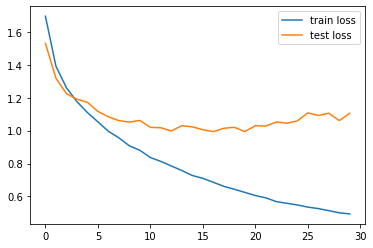

In [12]:
plot_test_and_train_metric(train_losses_CNN, test_losses_CNN,"loss")

In [13]:
train_acc_CNN = acc_compouter(model_CNN,device,train_loader,model_mode="CNN")
print(f"train acc: {train_acc_CNN}")

test_acc_CNN = acc_compouter(model_CNN,device,test_loader,model_mode="CNN")
print(f"test acc: {test_acc_CNN}")

train acc: 0.83542
test acc: 0.6639


Confusion matrix, without normalization
[[753  24  65  13  21   6  10  12  62  34]
 [ 29 763  12   9   3   2  10   6  52 114]
 [ 77  10 504  72  95  68  92  52  17  13]
 [ 30  10  79 461  73 172  88  57  13  17]
 [ 25   7  89  48 616  45  60  94  15   1]
 [ 30  10  58 197  55 525  32  70  10  13]
 [ 17  11  42  58  71  21 736  12  18  14]
 [ 19   8  25  32  60  58   2 760   6  30]
 [ 95  36  19   6  13   6   7  10 780  28]
 [ 54 100   8  14   6  10   9  20  28 751]]


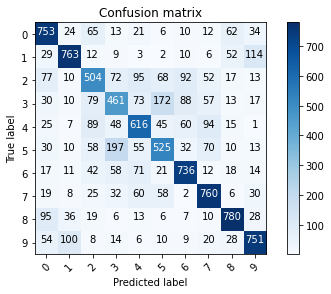

In [14]:
p_test_CNN,y_test,x_test = predict_model(model_CNN,test_loader,test_dataset,device,model_mode="CNN",mode=1)

cm_CNN = confusion_matrix(y_test,p_test_CNN)
plot_confusion_matrix(cm_CNN, list(range(K)))

In [15]:
cifar_labels = '''airplane
automobile
bird
car
deer
dog
frog
horse
ship
truck
'''.split("\n")

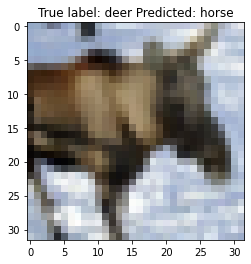

In [16]:
p_test_CNN = p_test_CNN.astype(np.uint8)
misclassified_idx = np.where(p_test_CNN!=y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i],cmap="gray")
plt.title("True label: %s Predicted: %s" % (cifar_labels[y_test[i]], cifar_labels[int(p_test_CNN[i])]));

### 2.Linear

In [21]:
model_Linear, train_losses_Linear, test_losses_Linear, device ,train_loader, test_loader = create_model_and_train(K,train_dataset,test_dataset,model_mode="Linear",batch_size=128,n_epochs=50)

cuda:0
Epoch 1/50, Train Loss: 2.2084, Test Loss: 2.0674, Duration: 0:01:17.407026
Epoch 2/50, Train Loss: 2.0488, Test Loss: 2.0280, Duration: 0:01:17.675020
Epoch 3/50, Train Loss: 2.0171, Test Loss: 2.0029, Duration: 0:01:18.264376
Epoch 4/50, Train Loss: 1.9841, Test Loss: 1.9550, Duration: 0:01:18.283609
Epoch 5/50, Train Loss: 1.9261, Test Loss: 1.8470, Duration: 0:01:18.223253
Epoch 6/50, Train Loss: 1.8204, Test Loss: 1.7551, Duration: 0:01:18.255776
Epoch 7/50, Train Loss: 1.7631, Test Loss: 1.7828, Duration: 0:01:18.202528
Epoch 8/50, Train Loss: 1.7190, Test Loss: 1.6876, Duration: 0:01:18.183608
Epoch 9/50, Train Loss: 1.6672, Test Loss: 1.6613, Duration: 0:01:18.202539
Epoch 10/50, Train Loss: 1.6226, Test Loss: 1.6328, Duration: 0:01:18.155600
Epoch 11/50, Train Loss: 1.5902, Test Loss: 1.5960, Duration: 0:01:18.125588
Epoch 12/50, Train Loss: 1.5590, Test Loss: 1.5470, Duration: 0:01:18.057715
Epoch 13/50, Train Loss: 1.5254, Test Loss: 1.5481, Duration: 0:01:18.094305
E

#### Evaluate model and plot results

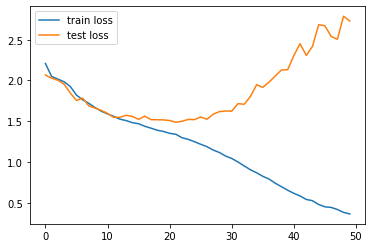

In [22]:
plot_test_and_train_metric(train_losses_Linear, test_losses_Linear,"loss")

In [23]:
train_acc_Linear = acc_compouter(model_Linear,device,train_loader,model_mode="Linear")
print(f"train acc: {train_acc_Linear}")

test_acc_Linear = acc_compouter(model_Linear,device,test_loader,model_mode="Linear")
print(f"test acc: {test_acc_Linear}")

train acc: 0.89906
test acc: 0.4467


Confusion matrix, without normalization
[[551  51  59  33  57  17  22  24 138  48]
 [ 72 540  24  30  25  18  34  27 107 123]
 [ 78  22 337  88 163  78 101  91  24  18]
 [ 27  22  95 293  89 178 113  93  47  43]
 [ 62   9 173  66 356  36 114 139  26  19]
 [ 29  23  94 201  75 314  79 109  36  40]
 [ 22  21 106 130 147  54 439  45  13  23]
 [ 53  27  64  64  88  63  30 538  23  50]
 [ 98  61  19  32  28  13  25  20 642  62]
 [ 63 213  12  46  19  21  26  48  95 457]]


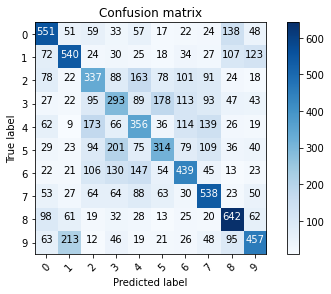

In [24]:
p_test_Linear,y_test,x_test = predict_model(model_Linear,test_loader,test_dataset,device,model_mode="Linear",mode=1)

cm_Linear = confusion_matrix(y_test,p_test_Linear)
plot_confusion_matrix(cm_Linear, list(range(K)))

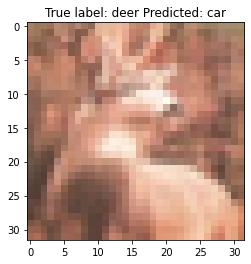

In [25]:
p_test_Linear = p_test_Linear.astype(np.uint8)
misclassified_idx = np.where(p_test_Linear!=y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i],cmap="gray")
plt.title("True label: %s Predicted: %s" % (cifar_labels[y_test[i]], cifar_labels[int(p_test_Linear[i])]));